
# **Valuation of Asian Options using the Lévy Approximation**

Course: FE 620: Pricing & Hedging | Stevens Institute of Technology

Advisor: Dan Pirjol

Group: Theo Dimitrasopoulos, Will Kraemer, Vaikunth Seshadri, Snehal Rajguru

Link: https://colab.research.google.com/drive/1fkbdI6gv3XV-pRJINI3C9klRIuGylLDX

*Version: v21.0*

## **Comments**

**Instructions:**

* Click the execution button on the top left corner of each code cell to execute it. To run all cells in descending order, go to the menu bar at the top and click Runtime -> Run all (or use the **Ctrl-F9** or **⌘-F9** hotkey for Windows and MacOSX respectively);
* If the code is running slowly, go to Runtime -> Change runtime type, and change the Runtime Shape to High-RAM from the dropdown menu;
* The **"!pip install"** lines under the Python packages section (i.e. lines 3-5) only need to be executed the first time you run the notebook. If you receive the message **"Requirement already satisfied:"**, wrap them in treble quotes (add the quotes in lines 2 & 6)*.


**Professor feedback:**
* You could repeat the MC simulation for 100,1000,10k runs and plot the errors vs #runs. The error should scale like 1/sqrt(runs). A log-log plot should be a line with slope -1/2. [DONE]
* An additional test could take several numbers of MC samples (iterations) and plot the log(error) vs log(iterations). Even 2 or 3 points would be sufficient. They should line up on a straight line with slope -0.5 corresponding to the 1/sqrt(N) scaling expected for MC simulations [DONE].

## **Python Packages**

In [0]:
# Install packages
'''
!pip install -q numpy
!pip install -q matplotlib
!pip install -q scipy
!pip install -q quandl
!pip install -q yfinance
!pip install -q pandas
!pip install quantsbin
'''
# Import Packages
import math
import random
import numpy as np
#######
from scipy.stats import norm
from scipy.integrate import quad
#######
import matplotlib as mpl
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
from matplotlib import cm
#######
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#######
#import pandas as pd
#import quandl
#import timeit

## **Variables**

### Model Variables

In [0]:
# Initial Underlying Price
S0 = 100#@param {type:"number"}

# Risk-free rate (also known as the drift coefficient)
r = 0.01#@param {type:"number"}

# Dividend Yield Rate
q = 0.0#@param {type:"number"}

# Valuation Date
t = 0.0#@param {type:"number"}

# Maturity
T = 1.0#@param {type:"number"}

# Strike
K = 105#@param {type:"number"}

# Volatility (also known as the diffusion coefficient)
sigma = 0.1#@param {type:"number"}

# Number of Iterations for Monte Carlo Simulation
iterations = 100000#@param {type:"integer"}

# Time Steps
timesteps = 100000#@param {type:"integer"}

### Plot Variables

In [0]:
# Universal Plot width
width = 25 #@param {type:"integer"}

# Universal Plot height
height =  14#@param {type:"integer"}

# Universal xtick size
xtick_size = 8 #@param {type:"integer"}

# Universal ytick size
ytick_size =  8#@param {type:"integer"}

# Universal title font size
title_size = 15 #@param {type:"integer"}

# Universal xlabel font size
xlabel_size = 12 #@param {type:"integer"}

# Universal xlabel font size
ylabel_size = 12 #@param {type:"integer"}

# Universal zlabel font size
zlabel_size = 12 #@param {type:"integer"}

# Universal legend font size
legend_size = 10 #@param {type:"integer"}

# Universal plot font color
color_plots = 'w'

In [0]:
plt.rcParams['figure.figsize'] = (width,height)
params = {'text.color' : 'black',
          'xtick.color' : color_plots,
          'ytick.color' : color_plots,
          'xtick.labelsize' : xtick_size,
          'ytick.labelsize' : ytick_size,
          'legend.loc' : 'upper left',
         }
plt.rcParams.update(params)

## **Definitions**

### Brownian Path Generator

In [0]:
def bm_paths(timesteps):
  seed = random.random()
  dt = T / timesteps
  bt = np.random.normal(0., 1., timesteps)*np.sqrt(dt)
  W = np.cumsum(bt)
  return W

### Geometric Brownian Path Generator

#### Conventional Implementation:

In [0]:
def gbm_paths(S0,K,T,t,r,q,sigma,timesteps):
  dt = np.linspace(0, T, timesteps)
  bt = np.random.normal(0., 1., int(timesteps))*np.sqrt(T/timesteps)
  W = np.cumsum(bt)
  S = S0 * np.exp(sigma * W + (r - q - 0.5 * (sigma**2)) * dt)
  S = np.insert(S, 0, S0)
  return S

#### Tensorflow Implementation:

In [0]:
def tf_graph_gbm_paths():
  S0 = tf.placeholder(tf.float32)
  K = tf.placeholder(tf.float32)
  dt = tf.placeholder(tf.float32)
  T = tf.placeholder(tf.float32)
  sigma = tf.placeholder(tf.float32)
  r = tf.placeholder(tf.float32)
  dw = tf.placeholder(tf.float32)
  S_i = S0 * tf.cumprod(tf.exp((r-sigma**2/2)*dt+sigma*tf.sqrt(dt)*dw), axis=1)
  return (S0, K, dt, T, sigma, r, dw, S_i)

In [0]:
def tf_gbm_paths():
  (S0,K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
  def paths(S_zero, strk, maturity, riskfrate, volatility, seed, iterations, timesteps):
    if seed != 0:
      np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(iterations, timesteps)
    with tf.Session() as sess:
      delta_t = maturity / timesteps
      res = sess.run(S_i, 
                     {
                         S0: S_zero,
                         K : strk,
                         r : riskfrate,
                         sigma: volatility,
                         dt : delta_t,
                         T: maturity,
                         dw : stdnorm_random_variates})
      return res
  return paths

### Black-Scholes Theoretical Price
Call and Put Asian option prices with geometric averaging. The alternative implementation in Tensorlfow offers efficiency and includes the calculations of 1st 2nd and 3rd order Greeks.

#### Conventional Implementation

In [0]:
# Call Options:
def bsm_call(S0, K, T, t, r, q, sigma):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t))
  c = np.exp(-r * (T - t)) * (G0 * N(d1) - K * N(d2))
  return c

# Put Options:
def bsm_put(S0, K, T, t, r, q, sigma):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t))
  p = np.exp(-r * (T - t)) * (K * N(-d2) - G0 * N(-d1))
  return p

#### Tensorflow Implementation

In [0]:
# Sample Output
# [NET PRESENT VALUE, [DELTA, VEGA, THETA], [GAMMA, VANNA, CHARM], [VANNA, VOLGA, VETA], [SPEED, ZOMMA, COLOR], [N/A, ULTIMA, TOTTO]]

# Call Options:
def bsm_call_tf(enable_greeks = True):
    S0 = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    q = tf.placeholder(tf.float32)    
    G0 = S0 * tf.exp(0.5 * (r * dt) - ((tf.math.square(sigma)) * dt)/12)
    Sigma_G = sigma/tf.sqrt(3.0)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) + 0.5 * (tf.math.square(Sigma_G)) * dt)
    d_2 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) - 0.5 * (tf.math.square(Sigma_G)) * dt)
    npv =  tf.exp(-r * dt) * (G0 * Phi(d_1) - K * Phi(d_2))                # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def execute_graph(S_zero, strk, maturity, riskfrate, volatility):
        with tf.Session() as sess:
            res = sess.run(target_calc, 
                           {
                               S0: S_zero,
                               K : strk,
                               r : riskfrate,
                               sigma: volatility,
                               dt: maturity})
        return res
    return execute_graph

# Put Options:
def bsm_put_tf(enable_greeks = True):
    S0 = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    q = tf.placeholder(tf.float32)    
    G0 = S0 * tf.exp(0.5 * (r * dt) - ((tf.math.square(sigma)) * dt)/12)
    Sigma_G = sigma/tf.sqrt(3.0)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) + 0.5 * (tf.math.square(Sigma_G)) * dt)
    d_2 = (1/(Sigma_G * tf.sqrt(dt))) * (tf.log(G0/K) - 0.5 * (tf.math.square(Sigma_G)) * dt)
    npv =  tf.exp(-r * dt) * (K * Phi(-d_2) - G0 * Phi(-d_1))              # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def execute_graph(S_zero, strk, maturity, riskfrate, volatility):
        with tf.Session() as sess:
            res = sess.run(target_calc, 
                           {
                               S0: S_zero,
                               K : strk,
                               r : riskfrate,
                               sigma: volatility,
                               dt: maturity})
        return res
    return execute_graph

### Monte Carlo Simulator with Arithmetic Average
Call and Put Asian option prices with arithmetic averaging. The alternative implementation in Tensorlfow offers efficiency and includes the calculations of 1st 2nd and 3rd order Greeks.

#### Conventional Interpretation

In [0]:
# Call Options:
def mc_call_arithm(S0, K, T, t, r, q, sigma,iterations,timesteps):
  mc_call_arithm_payoffs = []
  for i in range(1,iterations):
    S = gbm_paths(S0,K,T,t,r,q,sigma,timesteps)
    S_arithm = np.sum(S)/len(S)
    mc_call_arithm_payoffs.append(np.exp(-r * T) * max(S_arithm - K, 0))
  c = np.mean(mc_call_arithm_payoffs)
  return c

# Put Options:
def mc_put_arithm(S0, K, T, t, r, q, sigma,iterations,timesteps):
  mc_put_arithm_payoffs = []
  for i in range(1,it):
    S = gbm_paths(S0,K,T,t,r,q,sigma,timesteps)
    S_arithm = np.sum(S)/len(S)
    mc_put_arithm_payoffs.append(np.exp(-r * T) * max(K - S_arithm, 0))
  p = np.mean(mc_put_arithm_payoffs)
  return p

#### Tensorflow Implementation:

In [0]:
# Sample Output
# [NET PRESENT VALUE, [DELTA, VEGA, THETA], [GAMMA, VANNA, CHARM], [VANNA, VOLGA, VETA], [SPEED, ZOMMA, COLOR], [N/A, ULTIMA, TOTTO]]

# Call Options:
def mc_call_arithm_tf(enable_greeks=False):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.reduce_sum(S_i, axis=1)/(T/dt)
    payout = tf.maximum(A - K, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
      greeks = tf.gradients(npv, [S0, sigma, dt]) # delta, vega, theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt]) # gamma, vanna, charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt]) # vanna, vomma/volga, veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt]) # speed, zomma, color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt]) # N/A, ultima, totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, volatility, riskfrate, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer


# Put Options:
def mc_put_arithm_tf(enable_greeks=False):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.reduce_sum(S_i, axis=1)/(T/dt)
    payout = tf.maximum(K - A, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
      greeks = tf.gradients(npv, [S0, sigma, dt]) # delta, vega, theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt]) # gamma, vanna, charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt]) # vanna, vomma/volga, veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt]) # speed, zomma, color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt]) # N/A, ultima, totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, volatility, riskfrate, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer

### Monte Carlo Simulator with Geometric Average

#### Conventional Implementation

In [0]:
# Call Options:
def mc_call_geom(S0, K, T, t, r, q, sigma,iterations,timesteps):
  mc_call_geom_payoffs = []
  for i in range(1,iterations):
    S = gbm_paths(S0,K,T,t,r,q,sigma,timesteps)
    S_geom_mu = np.exp(np.mean(np.log(S)))
    mc_call_geom_payoffs.append(np.exp(-r * T) * max(S_geom_mu - K, 0))
  c = np.mean(mc_call_geom_payoffs)
  return c

# Put Options:
def mc_put_geom(S0, K, T, t, r, q, sigma,iterations,timesteps):
  mc_put_geom_payoffs = []
  for i in range(1,iterations):
    S = gbm_paths(S0,K,T,t,r,q,sigma,timesteps)
    S_geom = np.exp(np.mean(np.log(S)))
    mc_put_geom_payoffs.append(np.exp(-r * T) * max(K - S_geom, 0))
  p = np.mean(mc_put_geom_payoffs)
  return p

#### Tensorflow Implementation

In [0]:
# Sample Output
# [NET PRESENT VALUE, [DELTA, VEGA, THETA], [GAMMA, VANNA, CHARM], [VANNA, VOLGA, VETA], [SPEED, ZOMMA, COLOR], [N/A, ULTIMA, TOTTO]]

# Call Options:
def mc_call_geom_tf(enable_greeks=True):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.pow(tf.reduce_prod(S_i, axis=1), dt / T)
    payout = tf.maximum(A - K, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)                          # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #
      grads_greeks = tf.ones([iterations,1])                               #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, riskfrate, volatility, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer

# Put Options:
def mc_put_geom_tf(enable_greeks=True):
    (S0, K, dt, T, sigma, r, dw, S_i) = tf_graph_gbm_paths()
    A = tf.pow(tf.reduce_prod(S_i, axis=1), dt / T)
    payout = tf.maximum(K - A, 0)
    npv = tf.exp(-r * T) * tf.reduce_mean(payout)                          # GREEKS TABLE:
    target_calc = [npv]                                                    # (e.g. Option Price with respect to Asset Price (S) is delta)
    if enable_greeks:                                                      #                Asset Price (S)   Volatility    Time to Expiry
      greeks = tf.gradients(npv, [S0, sigma, dt])                          # Option Price |     delta            vega           theta
      dS_2nd = tf.gradients(greeks[0], [S0, sigma, dt])                    # Delta        |     gamma            vanna          charm
      dsigma_2nd = tf.gradients(greeks[1], [S0, sigma, dt])                # Vega         |     vanna         vomma/volga       veta
      dT_2nd = tf.gradients(dS_2nd[0], [S0, sigma, dt])                    # Gamma        |     speed            zomma          color
      dsigma_3rd = tf.gradients(dsigma_2nd[1], [S0, sigma, dt])            # Vomma        |      N/A             ultima         totto
      target_calc += [greeks, dS_2nd, dsigma_2nd, dT_2nd, dsigma_3rd]
    def pricer(S_zero, strk, maturity, riskfrate, volatility, seed, iterations, timesteps):
      if seed != 0:
        np.random.seed(seed)
      stdnorm_random_variates = np.random.randn(iterations, timesteps)
      with tf.Session() as sess:
        delta_t = maturity / timesteps
        res = sess.run(target_calc,
                       {
                           S0: S_zero,
                           K: strk,
                           r: riskfrate,
                           sigma: volatility,
                           dt: delta_t,
                           T: maturity,
                           dw: stdnorm_random_variates})
        return res
    return pricer

### PDF, CDF Analytical Calculations:

In [0]:
# Probability density function of standard normal
def dN(x):
  return math.exp(-0.5 * x ** 2) / math.sqrt(2 * math.pi)

# Cumulative density function of standard normal
def N(u):
  q = math.erf(u / math.sqrt(2.0))
  return (1.0 + q) / 2.0

### Greeks

#### Greeks Derivations

In [0]:
# 1st Order Greeks:

# Delta
def bsm_delta(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  if(optiontype == "Call"):
    delta = np.exp(-(T-t))*N(d1)
  elif(optiontype == "Put"):
    delta = -np.exp(-(T-t))*N(-d1)
  return delta

# Vega
def bsm_vega(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  vega = S0 * norm.pdf(d1) * math.sqrt(T - t)
  return vega

# Rho
def bsm_rho(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)  
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t))
  if(optiontype == "Call"):
    rho = K * (T - t) * math.exp(-r * (T - t)) * N(d2)
  if(optiontype == "Put"):
    rho = -K * (T - t) * math.exp(-r * (T - t)) * N(-d2)
  return rho

# Theta
def bsm_theta(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t))
  if(optiontype == "Call"):
    theta = -(S0 * norm.pdf(d1) * Sigma_G / (2 * math.sqrt(T - t)) - r * K * math.exp(-r * (T - t)) * N(d2))
  if(optiontype == "Put"):
    theta = -(S0 * norm.pdf(d1) * Sigma_G / (2 * math.sqrt(T - t)) + r * K * math.exp(-r * (T - t)) * N(-d2))
  return theta

# 2nd Order Greeks:

# Gamma
def bsm_gamma(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  gamma = norm.pdf(d1) / (S0 * sigma * math.sqrt(T - t))
  return gamma

# Charm
def bsm_charm(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)  
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t)) 
  charm = -norm.pdf(d1) * (2 * r * (T-t) - d2 * Sigma_G * np.sqrt(T-t)) / (2 * (T - t) * Sigma_G * np.sqrt(T-t))
  return charm

# Phi
def bsm_phi(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)  
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t))
  phi = 0.01 * T * S0 * np.exp(-q * T) * N(d1)
  return phi

# Vanna
def bsm_vanna(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)  
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t))
  vanna = S0 * np.exp(-q * T) * d2 / Sigma_G * norm.pdf(d1) 
  return vanna

# Vomma
def bsm_vomma(S0, K, T, t, r, q, sigma, optiontype):
  G0 = S0 * np.exp(0.5 * (T - t) * (r - q - (sigma**2)/6))
  Sigma_G = sigma/np.sqrt(3)  
  d1 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * (T - t))
  d2 = (1/(Sigma_G * np.sqrt(T - t))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * (T - t))
  vomma = -0.01 * np.exp(-q * T) * d2 / Sigma_G * norm.pdf(d1)
  return vomma

#### Greeks: Sensitivity Multitool

In [0]:
def greeks_plot_tool(greek_function, x_var_name, y_var_name,S0, K, T, t, r, q, sigma, x, y, optiontype, greek, plot):
    # Initialise vector to store our option values and then iterate over
    # Assumption that we're using a constant sized vector length for each variable
    # Need to change the variables being iterated over here for each update (possibly a better way to do this)
    V = np.zeros((len(S0), len(S0)), dtype=np.float)
    for i in range(len(S0)):
      for j in range(len(S0)):
        V[i, j] = greek_function(S0[i], K[i], T[j], t[i], r[i], q[i], sigma[i], optiontype)
 
    # Initiliase plotting canvas 
    surf = plot.plot_surface(x, y, V, rstride=1, cstride=1,alpha=0.75,cmap=cm.RdYlBu, antialiased = True)
    plot.set_xlabel(x_var_name)
    plot.set_ylabel(y_var_name)
    plot.set_zlabel("%s(K, T)" % greek)
    plot.set_title("%s %s" % (optiontype, greek))
    
    # Calculate colour levels based on our meshgrid
    Vlevels = np.linspace(V.min(),V.max(),num=8,endpoint=True)
    xlevels = np.linspace(x.min(),x.max(),num=8,endpoint=True)
    ylevels = np.linspace(y.min(),y.max(),num=8,endpoint=True)
    
    cset = plot.contourf(x, y, V, Vlevels, zdir='z',offset=V.min(), cmap=cm.RdYlBu,alpha = 0.5, antialiased = True)
    cset = plot.contourf(x, y, V, xlevels, zdir='x',offset=x.min(), cmap=cm.RdYlBu,alpha = 0.5, antialiased = True)
    cset = plot.contourf(x, y, V, ylevels, zdir='y',offset=y.max(), cmap=cm.RdYlBu,alpha = 0.5, antialiased = True)

    # Set our viewing constraints
    for c in cset.collections:
      c.set_dashes([(0, (2.0, 2.0))]) # Dash contours 
    plt.clabel(cset,fontsize=10, inline=1)
    plot.set_xlim(x.min(),x.max())
    plot.set_ylim(y.min(),y.max())
    plot.set_zlim(V.min(),V.max())

    # Colorbar
    colbar = plt.colorbar(surf, shrink=1.0, extend='both', aspect = 10)
    l,b,w,h = plt.gca().get_position().bounds
    ll,bb,ww,hh = colbar.ax.get_position().bounds
    colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])

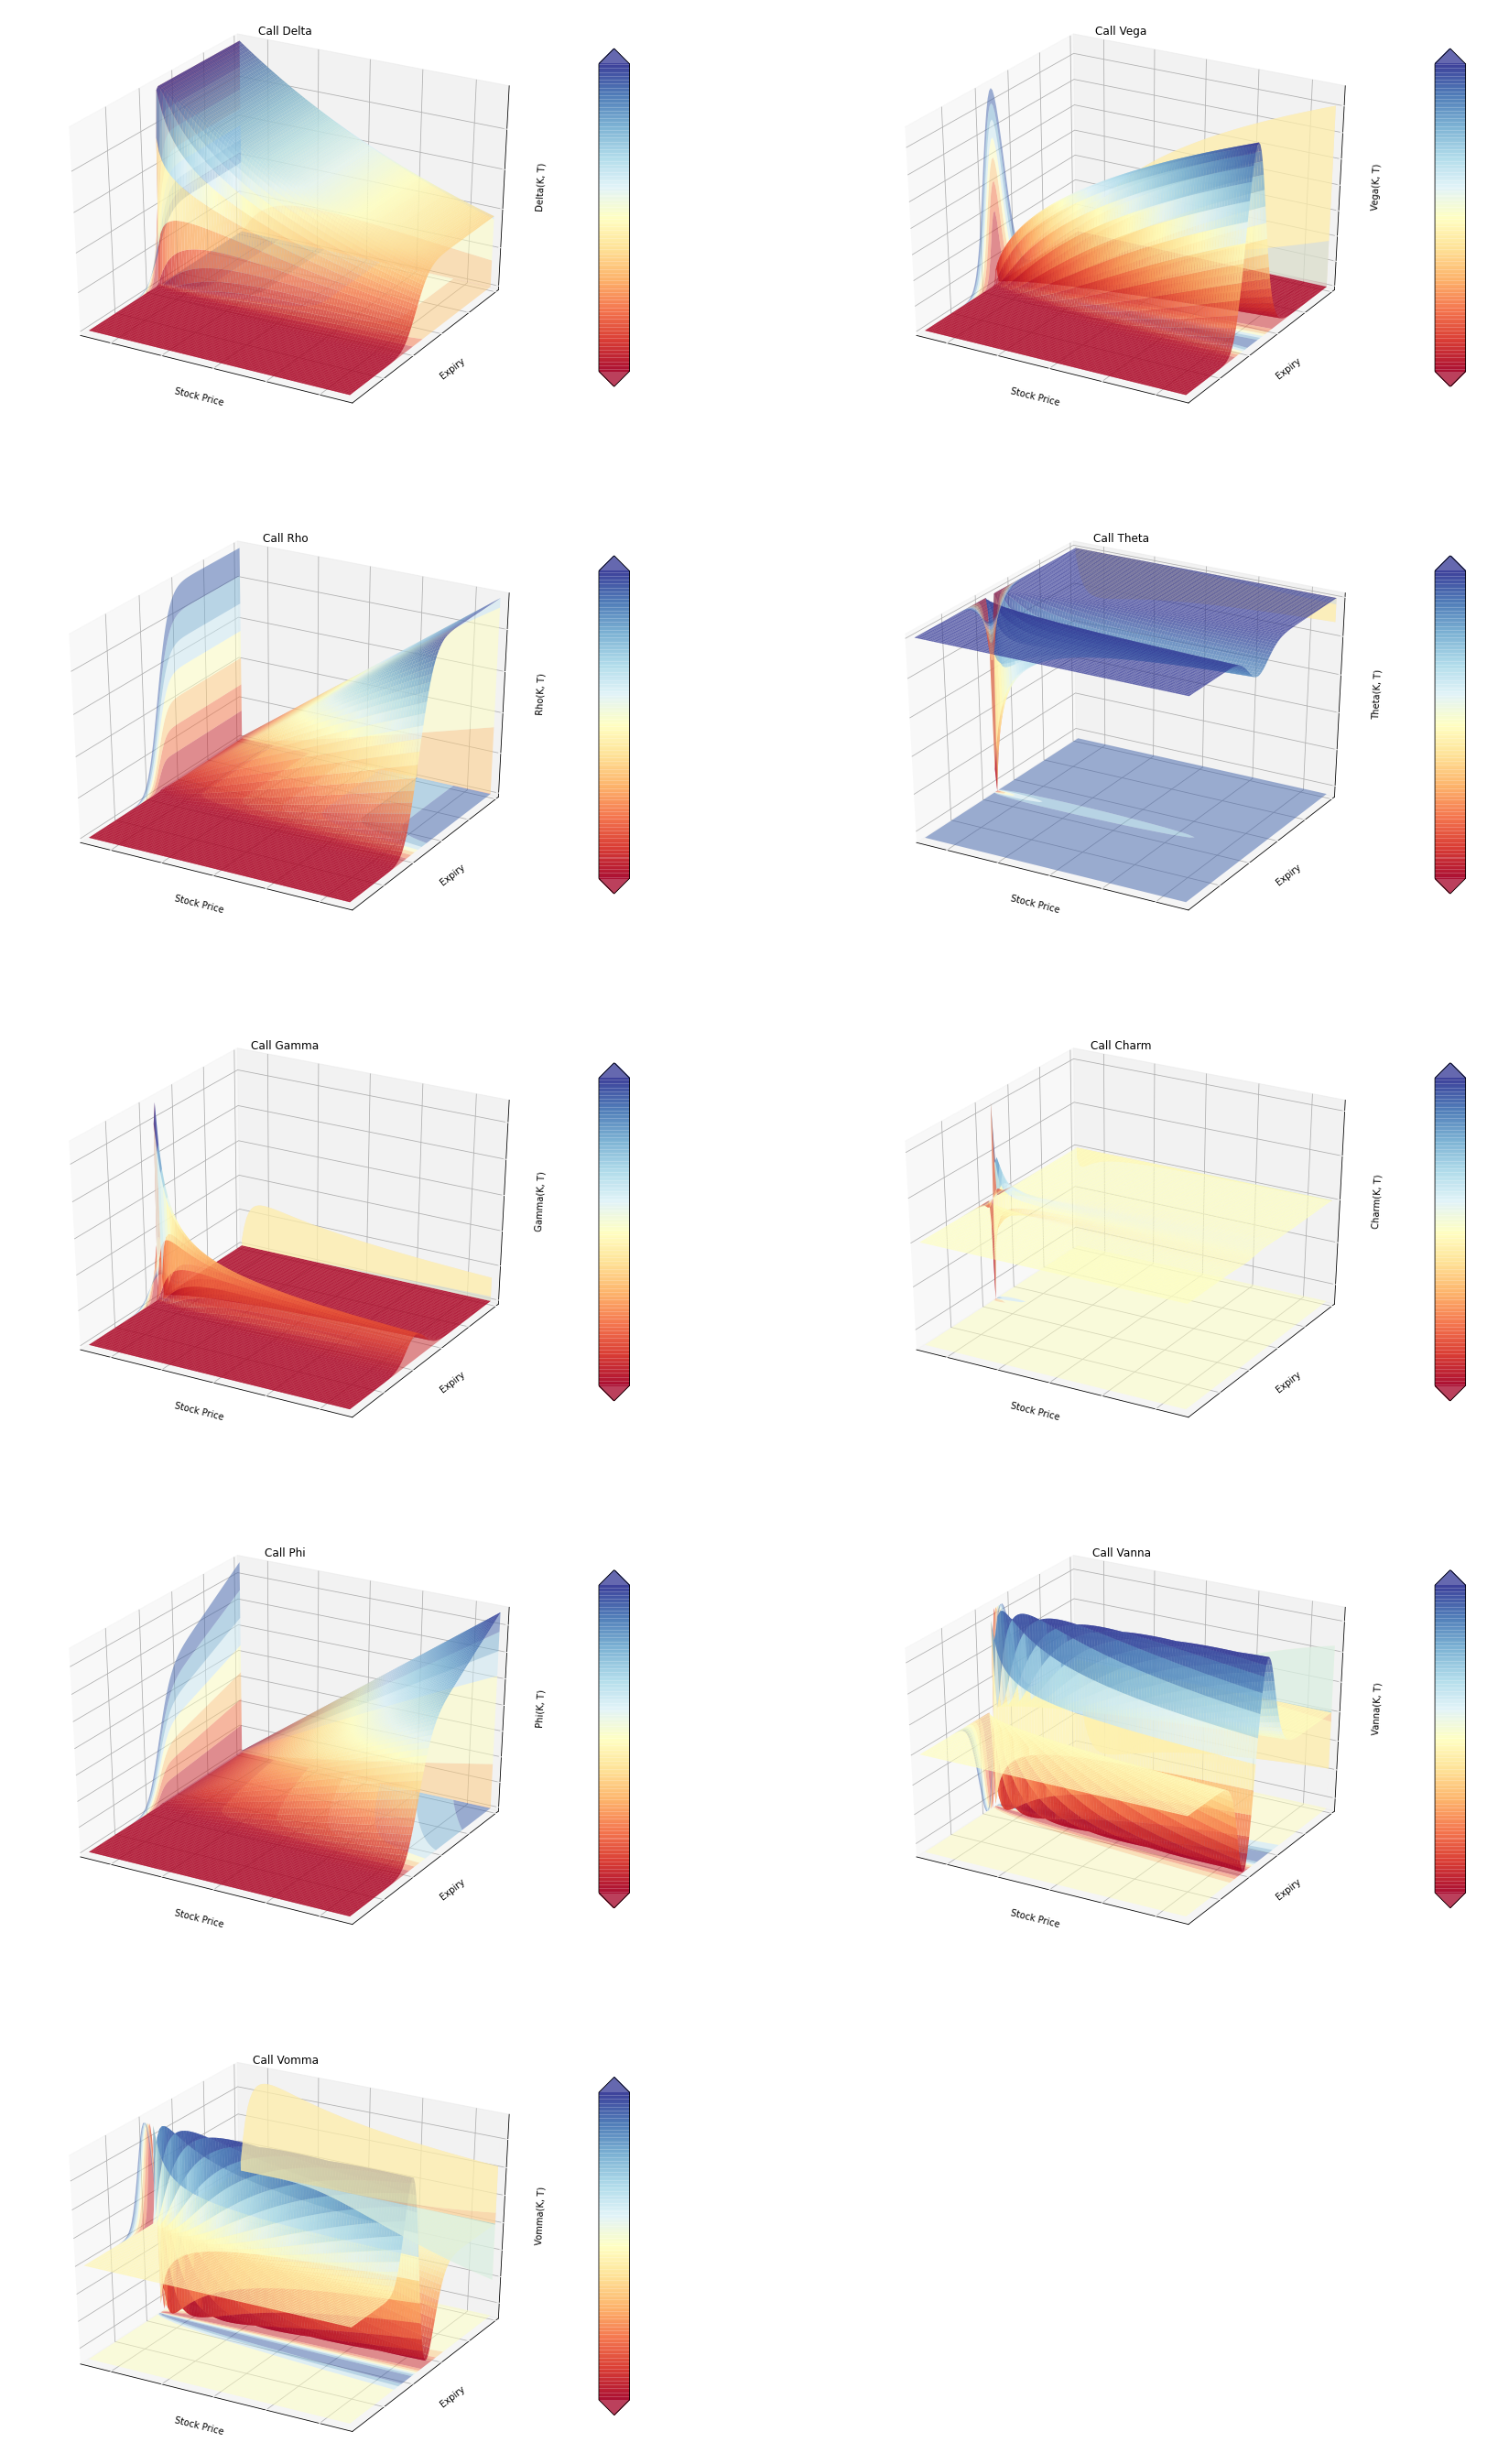

In [34]:
# Test
S0 = np.linspace(50, 150, 100)
K = np.linspace(95.0,95.0, 100)
T = np.linspace(0.01, 1.0, 100)
t = np.linspace(0.0, 0.0, 100)
r = np.linspace(0.0, 0.0, 100)
sigma = np.linspace(0.12, 0.12, 100)
q = np.linspace(0.0,0.0,100)

x, y  = np.meshgrid(S0, T)
fig = plt.figure(figsize=(30,90))
greeks = [bsm_delta, bsm_vega, bsm_rho, bsm_theta, bsm_gamma, bsm_charm, bsm_phi, bsm_vanna, bsm_vomma]
greeks_names = ['Delta', 'Vega', 'Rho', 'Theta', 'Gamma', 'Charm', 'Phi', 'Vanna', 'Vomma']
for i in range(len(greeks)):
    ax = fig.add_subplot(len(greeks), 2, i+1, projection='3d')
    greeks_plot_tool(greeks[i],"Stock Price", "Expiry", S0, K, T, t, r, q, sigma, x, y, "Call", greeks_names[i], ax)

plt.show()

#### Greeks: Sensitivity to Time and Stock/Underlying Price


In [0]:
def plot_greeks_bsm(function, greek, optiontype):
  points = 100
  tlist = np.linspace(0.0001, T, points)
  klist = [95,100,105]
  s0list = np.linspace(50,150,points)
  V_c_1 = np.zeros((len(s0list), len(tlist)), dtype=np.float)
  V_p_1 = np.zeros((len(s0list), len(tlist)), dtype=np.float)
  V_c_2 = np.zeros((len(s0list), len(tlist)), dtype=np.float)
  V_p_2 = np.zeros((len(s0list), len(tlist)), dtype=np.float)
  V_c_3 = np.zeros((len(s0list), len(tlist)), dtype=np.float)
  V_p_3 = np.zeros((len(s0list), len(tlist)), dtype=np.float)
  for j in range(len(tlist)):
    for i in range(len(s0list)):
      V_c_1[i, j] = function(s0list[i], klist[0], tlist[i], t, r, q, sigma, "Call")
      V_p_1[i, j] = function(s0list[i], klist[0], tlist[i], t, r, q, sigma, "Put")
      V_c_2[i, j] = function(s0list[i], klist[1], tlist[i], t, r, q, sigma, "Call")
      V_p_2[i, j] = function(s0list[i], klist[1], tlist[i], t, r, q, sigma, "Put")
      V_c_3[i, j] = function(s0list[i], klist[2], tlist[i], t, r, q, sigma, "Call")
      V_p_3[i, j] = function(s0list[i], klist[2], tlist[i], t, r, q, sigma, "Put")
  fig = plt.figure(figsize=(width,height))
  x, y = np.meshgrid(tlist, s0list)
  plot = p3.Axes3D(fig)
  plot.patch.set_alpha(0.0)
  plot.plot_wireframe(x, y, V_c_1, linewidth=1.0, color = color_plots, alpha = 0.5) #, for surface plotting
  plot.plot_surface(y,x, V_p_1, linewidth=1.0, color = 'red', alpha = 0.9, antialiased=True, rstride = 1, cstride = 1) #cmap = cm.RdYlGn, for surface plotting # , rstride = 1, cstride = 1 for detailed mesh
  plot.plot_wireframe(x, y, V_c_2, linewidth=1.0, color = color_plots, alpha = 0.5) #, for surface plotting
  plot.plot_surface(y,x, V_p_2, linewidth=1.0, color = 'blue', alpha = 0.9, antialiased=True, rstride = 1, cstride = 1) #cmap = cm.RdYlGn, for surface plotting
  plot.plot_wireframe(x, y, V_c_3, linewidth=1.0, color = color_plots, alpha = 0.5) #, for surface plotting
  plot.plot_surface(y,x, V_p_3, linewidth=1.0, color = 'green', alpha = 0.9, antialiased=True, rstride = 1, cstride = 1) #cmap = cm.RdYlGn, for surface plotting
  plot.set_title('BSM %s Option Value vs. Time vs. Underlying Price' % optiontype, color = color_plots, fontsize = title_size)
  plot.set_xlabel('Maturity $T$', color = color_plots, fontsize = xlabel_size)
  plot.set_ylabel('Stock/Underlying Price ($)', color = color_plots, fontsize = ylabel_size)
  plot.set_zlabel('%s' % greek, color = color_plots, fontsize = zlabel_size)

In [39]:
# Test:
plot_greeks_bsm(bsm_delta, 'Delta', 'Call')

TypeError: ignored

#### Greeks: Sensitivity to Strike and Stock/Underlying Price


TypeError: ignored

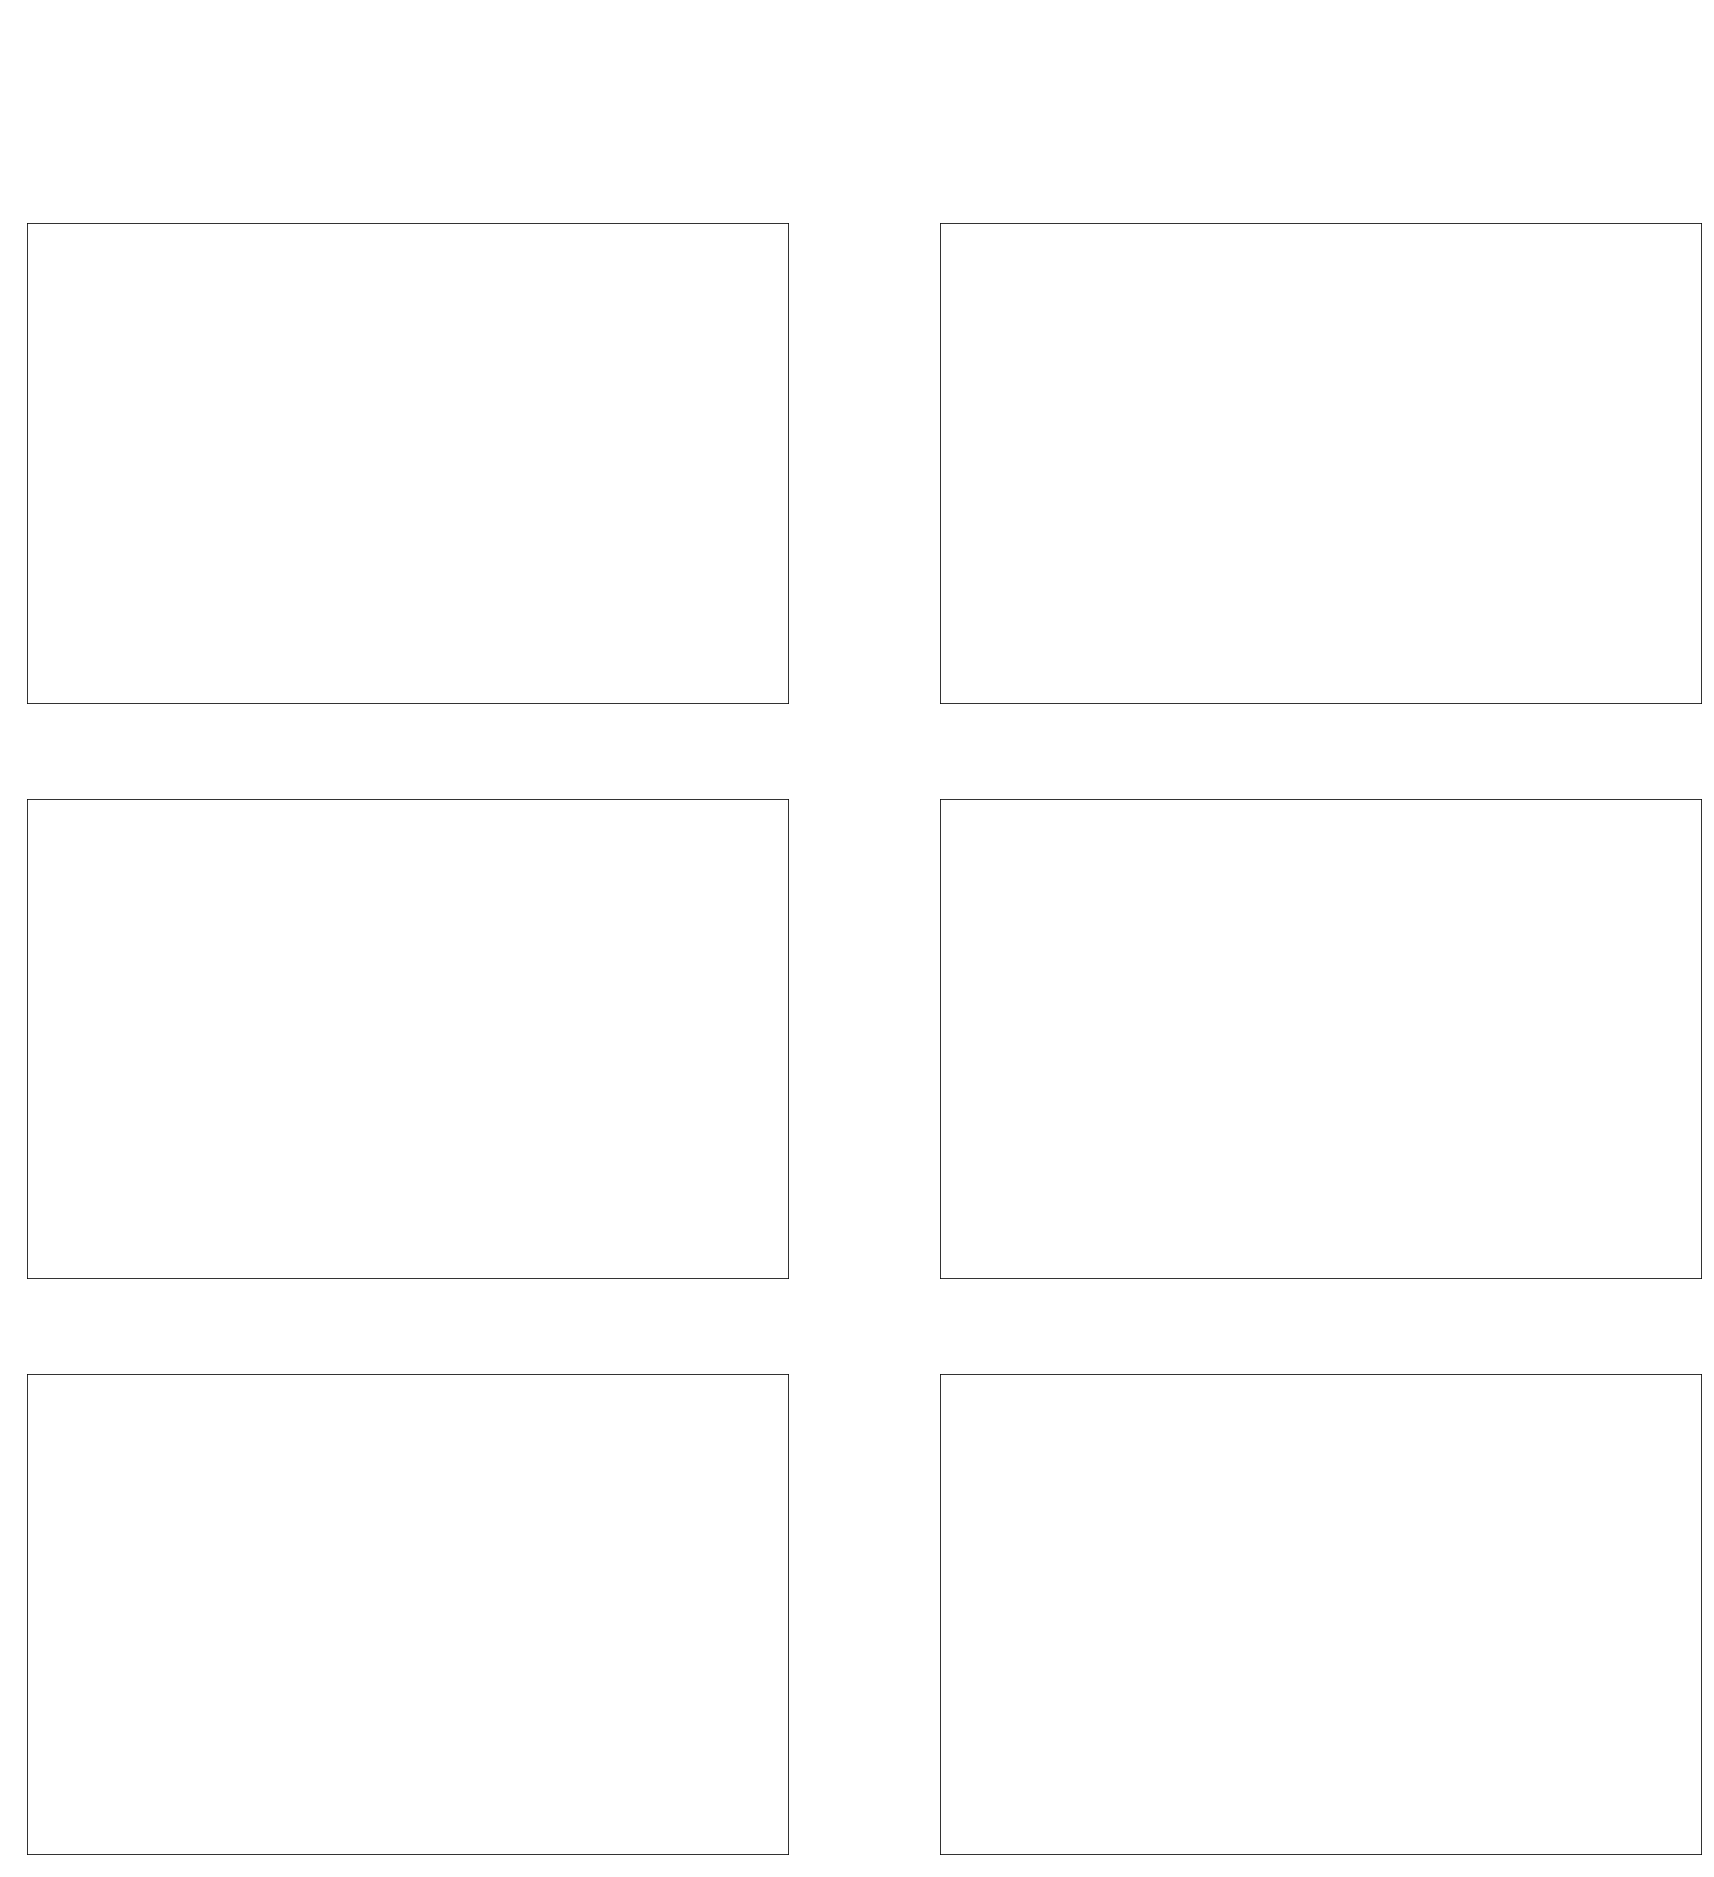

In [37]:
# 1st Order Greeks: Sensitivity to Strike and Stock/Underlying Price

fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(30, 30))
fig.suptitle('1st Order Greeks: Sensitivity to Strike and Stock/Underlying Price', color = color_plots, fontsize=title_size, fontweight='bold')
klist = [15,25,35]
slist = np.arange(1,100)
r = 0.01
sigma = 0.1
T = 10
t = 0.0

plt.subplot(321)
for i in klist:
    c = [bsm_gamma(S0, i, T, t, r, q, sigma, "Call") for S0 in slist]
    p = [bsm_gamma(S0, i, T, t, r, q, sigma, "Put") for S0 in slist]
    plt.plot(c, label = ("Delta Call K=%i" % i ))
    plt.plot(p, label = ("Delta Put K=%i" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Delta", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(322)
for i in klist:
    c = [bsm_gamma(S0, i, T, t, r, q, sigma, "Call") for S0 in slist]
    p = [bsm_gamma(S0, i, T, t, r, q, sigma, "Put") for S0 in slist]
    plt.plot(c, label = ("Gamma Call K=%i" % i ))
    plt.plot(p, label = ("Gamma Put K=%i" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Gamma", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(323)
for i in klist:
    c = [bsm_vega(S0, i, T, t, r, q, sigma, "Call") for S0 in slist]
    p = [bsm_vega(S0, i, T, t, r, q, sigma, "Put") for S0 in slist]
    plt.plot(c, label = ("Vega Call K=%i" % i ))
    plt.plot(p, label = ("Vega Put K=%i" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Vega", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(324)

for i in klist:
    c = [bsm_rho(S0, i, T, t, r, q, sigma, "Call") for S0 in slist]
    p = [bsm_rho(S0, i, T, t, r, q, sigma, "Put") for S0 in slist]
    plt.plot(c, label = ("Rho Call K=%i" % i ))
    plt.plot(p, label = ("Rho Put K=%i" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Rho", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(325)
for i in klist:
    c = [bsm_theta(S0, i, T, t, r, q, sigma, "Call") for S0 in slist]
    p = [bsm_theta(S0, i, T, t, r, q, sigma, "Put") for S0 in slist]
    plt.plot(c, label = ("Theta Call K=%i" % i ))
    plt.plot(p, label = ("Theta Put K=%i" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Theta", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(326)
for i in klist:
    c = [bsm_charm(S0, i, T, t, r, q, sigma, "Call") for S0 in slist]
    p = [bsm_charm(S0, i, T, t, r, q, sigma, "Put") for S0 in slist]
    plt.plot(c, label = ("Charm Call K=%i" % i ))
    plt.plot(p, label = ("Charm Put K=%i" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Charm", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)
plt.show()

#### Greeks: Sensitivity to Risk-Free Rate + Stock/Underlying Price

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(30, 30))
fig.suptitle('1st Order Greeks: Sensitivity to Risk-Free Rate + Stock/Underlying Price', color = color_plots, fontsize=title_size, fontweight='bold')
rlist = [0.0,0.01,0.1]
K = 15
r = 0.01
sigma = 0.1
T = 10
t = 0

plt.subplot(321)
for i in rlist:
    c = [bsm_delta(S0, K, T, t, i, q, sigma, "Call") for S0 in np.arange(1,100)]
    p = [bsm_delta(S0, K, T, t, i, q, sigma, "Put") for S0 in np.arange(1,100)]
    plt.plot(c, label = ("Delta Call r=%.2f" % i ))
    plt.plot(p, label = ("Delta Put r=%.2f" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Delta", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(322)
for i in rlist:
    c = [bsm_gamma(S0, K, T, t, i, q, sigma, "Call") for S0 in np.arange(1,100)]
    p = [bsm_gamma(S0, K, T, t, i, q, sigma, "Put") for S0 in np.arange(1,100)]
    plt.plot(c, label = ("Gamma Call r=%.2f" % i ))
    plt.plot(p, label = ("Gamma Put r=%.2f" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Gamma", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(323)
for i in rlist:
    c = [bsm_vega(S0, K, T, t, i, q, sigma, "Call") for S0 in np.arange(1,100)]
    p = [bsm_vega(S0, K, T, t, i, q, sigma, "Put") for S0 in np.arange(1,100)]
    plt.plot(c, label = ("Vega Call r=%.2f" % i ))
    plt.plot(p, label = ("Vega Put r=%.2f" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Vega", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(324)

for i in rlist:
    c = [bsm_rho(S0, K, T, t, i, q, sigma, "Call") for S0 in np.arange(1,100)]
    p = [bsm_rho(S0, K, T, t, i, q, sigma, "Put") for S0 in np.arange(1,100)]
    plt.plot(c, label = ("Rho Call r=%.2f" % i ))
    plt.plot(p, label = ("Rho Put r=%.2f" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Rho", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(325)
for i in rlist:
    c = [bsm_theta(S0, K, T, t, i, q, sigma, "Call") for S0 in np.arange(1,100)]
    p = [bsm_theta(S0, K, T, t, i, q, sigma, "Put") for S0 in np.arange(1,100)]
    plt.plot(c, label = ("Theta Call r=%.2f" % i ))
    plt.plot(p, label = ("Theta Put r=%.2f" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Theta", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)

plt.subplot(326)
for i in rlist:
    c = [bsm_charm(S0, K, T, t, i, q, sigma, "Call") for S0 in np.arange(1,100)]
    p = [bsm_charm(S0, K, T, t, i, q, sigma, "Put") for S0 in np.arange(1,100)]
    plt.plot(c, label = ("Charm Call r=%.2f" % i ))
    plt.plot(p, label = ("Charm Put r=%.2f" % i ))

plt.xlabel('Stock/Underlying Price ($)', color = color_plots, fontsize = xlabel_size)
plt.ylabel("Charm", color = color_plots, fontsize = ylabel_size)
plt.legend(fontsize = legend_size)
plt.show()

### Option Sensitivity

#### BSM Options: Sensitivity to all parameters

In [0]:
def bsm_plot_values(function,S0, K, T, t, r, q, sigma,optiontype):
    fig = plt.figure(figsize=(30,90))
    points = 100

    # Option(K,T) vs. Strike
    fig1 = fig.add_subplot(821)
    klist = np.linspace(K-30, K+30, points)
    vlist = [function(S0, K, T, t, r, q, sigma) for K in klist]
    fig1.plot(klist, vlist)
    fig1.grid()
    fig1.set_title('BSM %s Option Value vs. Strike' % optiontype, color = color_plots, fontsize = title_size)
    fig1.set_xlabel('Strike $K$', color = color_plots, fontsize = xlabel_size)
    fig1.set_ylabel('%s Option Value' % optiontype, color = color_plots, fontsize = ylabel_size)

    # Option(K,T) vs. Strike vs. Underlying Price
    klist = np.linspace(K-30, K+30, points)
    s0list = np.linspace(S0 - 20, S0 + 20, points)
    V = np.zeros((len(s0list), len(klist)), dtype=np.float)
    for j in range(len(klist)):
      for i in range(len(s0list)):
        V[i, j] = function(s0list[i], klist[j], T, t, r, q, sigma)

    fig2 = fig.add_subplot(823, projection="3d")
    x, y = np.meshgrid(klist, s0list)
    fig2.patch.set_alpha(0.0)
    fig2.plot_wireframe(x, y, V, linewidth=1.0, color = color_plots) #cmap = cm.RdYlGn, for surface plotting
    fig2.set_title('BSM %s Option Value vs. Strike vs. Underlying Price' % optiontype, color = color_plots, fontsize = title_size)
    fig2.set_xlabel('Strike $K$', color = color_plots, fontsize = xlabel_size)
    fig2.set_ylabel('Stock/Underlying Price ($)', color = color_plots, fontsize = ylabel_size)
    fig2.set_zlabel('%s Option Value' % optiontype, color = color_plots, fontsize = zlabel_size)

    # Option(K,T) vs. Time
    fig3 = fig.add_subplot(822)
    tlist = np.linspace(0.0001, T, points)
    vlist = [function(S0, K, T, t, r, q, sigma) for T in tlist]
    fig3.plot(tlist, vlist)
    fig3.grid()
    fig3.set_title('BSM %s Option Value vs. Time' % optiontype, color = color_plots, fontsize = title_size)
    fig3.set_xlabel('Maturity $T$', color = color_plots, fontsize = xlabel_size)
    fig3.set_ylabel('%s Option Value' % optiontype, color = color_plots, fontsize = ylabel_size)

    # Option(K,T) vs. Time vs. Underlying Price
    tlist = np.linspace(0.0001, T, points)
    s0list = np.linspace(S0 - 20, S0 + 10, points)
    V = np.zeros((len(s0list), len(tlist)), dtype=np.float)
    for j in range(len(tlist)):
      for i in range(len(s0list)):
        V[i, j] = function(s0list[i], K, tlist[j], t, r, q, sigma)

    fig4 = fig.add_subplot(824, projection="3d")
    x, y = np.meshgrid(tlist, s0list)
    fig4.patch.set_alpha(0.0)
    fig4.plot_wireframe(x, y, V, linewidth=1.0, color = color_plots) #cmap = cm.RdYlGn, for surface plotting
    fig4.set_title('BSM %s Option Value vs. Time vs. Underlying Price' % optiontype, color = color_plots, fontsize = title_size)
    fig4.set_xlabel('Maturity $T$', color = color_plots, fontsize = xlabel_size)
    fig4.set_ylabel('Stock/Underlying Price ($)', color = color_plots, fontsize = ylabel_size)
    fig4.set_zlabel('%s Option Value' % optiontype, color = color_plots, fontsize = zlabel_size)

    # Option(K,T) vs. r
    fig5 = fig.add_subplot(825)
    rlist = np.linspace(0, r, points)
    vlist = [function(S0, K, T, t, r, q, sigma) for r in rlist]
    fig5.plot(rlist, vlist)
    fig5.grid()
    fig5.set_title('BSM %s Option Value vs. r' % optiontype, color = color_plots, fontsize = title_size)
    fig5.set_xlabel('Risk-free rate $r$', color = color_plots, fontsize = xlabel_size)
    fig5.set_ylabel('%s Option Value' % optiontype, color = color_plots, fontsize = ylabel_size)

    # Option(K,T) vs. r vs. Underlying Price
    rlist = np.linspace(0, r, points)
    s0list = np.linspace(S0 - 20, S0 + 20, points)
    V = np.zeros((len(s0list), len(rlist)), dtype=np.float)
    for j in range(len(rlist)):
      for i in range(len(s0list)):
        V[i, j] = function(s0list[i], K, T, t, rlist[j], q, sigma)

    fig6 = fig.add_subplot(827, projection="3d")
    x, y = np.meshgrid(rlist, s0list)
    fig6.patch.set_alpha(0.0)
    fig6.plot_wireframe(x, y, V, linewidth=1.0, color = color_plots) #cmap = cm.RdYlGn, for surface plotting
    fig6.set_title('BSM %s(K:%d,T:%d) vs. r vs. Underlying Price' % (optiontype,K,T), color = color_plots, fontsize = title_size)
    fig6.set_xlabel('Risk-free rate $r$', color = color_plots, fontsize = xlabel_size)
    fig6.set_ylabel('Stock/Underlying Price ($)', color = color_plots, fontsize = ylabel_size)
    fig6.set_zlabel('%s Option Value' % optiontype, color = color_plots, fontsize = zlabel_size)

    # Option(K,T) vs. Implied Vol.
    fig7 = fig.add_subplot(826)
    slist = np.linspace(0.01, sigma, points)
    vlist = [function(S0, K, T, t, r, q, sigma) for sigma in slist]
    fig7.plot(slist, vlist)
    fig7.grid()
    fig7.set_title('BSM %s Option Value vs. Volatility' % optiontype, color = color_plots, fontsize = title_size)
    fig7.set_xlabel('Volatility $\sigma$', color = color_plots, fontsize = xlabel_size)
    fig7.set_ylabel('%s Option Value' % optiontype, color = color_plots, fontsize = ylabel_size)

    # Option(K,T) vs. Volatility vs. Underlying Price
    slist = np.linspace(0.01, sigma, points)
    s0list = np.linspace(S0 - 20, S0 + 20, points)
    V = np.zeros((len(s0list), len(slist)), dtype=np.float)
    for j in range(len(slist)):
      for i in range(len(s0list)):
        V[i, j] = function(s0list[i], K, T, t, r, q, slist[j])

    fig8 = fig.add_subplot(828, projection="3d")
    x, y = np.meshgrid(slist, s0list)
    fig8.patch.set_alpha(0.0)
    fig8.plot_wireframe(x, y, V, linewidth=1.0, color = color_plots) #cmap = cm.RdYlGn, for surface plotting
    fig8.set_title('BSM %s Option Value vs. Volatility vs. Underlying Price' % optiontype, color = color_plots, fontsize = title_size)
    fig8.set_xlabel('Volatility $\sigma$', color = color_plots, fontsize = xlabel_size)
    fig8.set_ylabel('Stock/Underlying Price ($)', color = color_plots, fontsize = ylabel_size)
    fig8.set_zlabel('%s Option Value' % optiontype, color = color_plots, fontsize = zlabel_size)

In [0]:
# Test
bsm_plot_values(bsm_call,100, 95, 1.0, 0.0, 0.15, 0.0, 0.3,'Call')

#### Monte Carlo Option Sensitivity

In [0]:
def mc_plot_values(function,S0,K,T,r,sigma,seed,iterations,timesteps,optiontype):
    #optiontype between 'C' and 'P'
    plt.figure(figsize=(20, 16.6))
    points = 1000

    # optiontype(K,T) vs. Strike
    plt.subplot(221)
    klist = np.linspace(K-30, K+30, points)
    vlist = [function(S0, K, T, r, sigma, seed, iterations, timesteps)[0] for K in klist]
    plt.plot(klist, vlist)
    plt.grid()
    plt.title('Monte Carlo %s(K:%d,T:%d) vs. Strike' % (optiontype,K,T), color = color_plots, fontsize = title_size)
    plt.xlabel('Strike $K$', color = color_plots, fontsize = xlabel_size)
    plt.ylabel('Present Value', color = color_plots, fontsize = ylabel_size)

    # optiontype(K,T) vs. Time
    plt.subplot(222)
    tlist = np.linspace(0.0001, T, points)
    vlist = [function(S0, K, T, r, sigma, seed, iterations, timesteps)[0] for T in tlist]
    plt.plot(tlist, vlist)
    plt.grid(True)
    plt.title('Monte Carlo %s(K:%d,T:%d) vs. Time' % (optiontype,K,T), color = color_plots, fontsize = title_size)
    plt.xlabel('Maturity $T$', color = color_plots, fontsize = xlabel_size)
    plt.ylabel('Present Value', color = color_plots, fontsize = ylabel_size)


    # optiontype(K,T) vs. r
    plt.subplot(223)
    rlist = np.linspace(0, r, points)
    vlist = [function(S0, K, T, r, sigma, seed, iterations, timesteps)[0] for r in rlist]
    plt.plot(tlist, vlist)
    plt.grid(True)
    plt.title('Monte Carlo %s(K:%d,T:%d) vs. r' % (optiontype,K,T), color = color_plots, fontsize = title_size)
    plt.xlabel('r rate $r$', color = color_plots, fontsize = xlabel_size)
    plt.ylabel('Present Value', color = color_plots, fontsize = ylabel_size)
    plt.axis('tight')

    # optiontype(K,T) vs. Implied Vol.
    plt.subplot(224)
    slist = np.linspace(0.01, sigma, points)
    vlist = [function(S0, K, T, r, sigma, seed, iterations, timesteps)[0] for sigma in slist]
    plt.plot(slist, vlist)
    plt.grid(True)
    plt.title('Monte Carlo %s(K:%d,T:%d) vs. Implied Volatility' % (optiontype,K,T), color = color_plots, fontsize = title_size)
    plt.xlabel('Implied Volatility $\sigma$', color = color_plots, fontsize = xlabel_size)
    plt.ylabel('Present Value', color = color_plots, fontsize = ylabel_size)
    plt.tight_layout()

## **Error Estimation**

### Black-Scholes vs. Monte Carlo: Call Options with Geometric Average

In [0]:
print('- - - - - - - - - - - - - - - - -')

for i in range(95,110,5):
  bs = bsm_call(S0, i, T, t, r, q, sigma)
  mc = mc_call_geom(S0, i, T, t, r, q, sigma,iterations,timesteps)
  error = np.abs((bs-mc)/bs)*100
  print('G_c(K=%d,T=%d):'%(i,T))
  print('Black-Scholes:',bs)
  print('Monte Carlo:', mc)
  print('Error: %f%%' % error)
  print('- - - - - - - - - - - - - - - - -')

### Black-Scholes vs. Monte Carlo: Put Options with Geometric Average

In [0]:
print('- - - - - - - - - - - - - - - - -')

for i in range(95,110,5):
  bs = bsm_put(S0, K, T, 0.0, r, q, sigma)
  mc = mc_put_geom(S0, K, T, t, r, q, sigma,iterations,timesteps)
  error = np.abs((bs-mc)/bs)*100
  print('G_p(K=%d,T=%d):'%(i,T))
  print('Black-Scholes:',repr(bs))
  print('Monte Carlo:',repr(mc))
  print('Error:',repr(error),'%')
  print('- - - - - - - - - - - - - - - - -')

### Asian call options with Arithmetic Average: Linetsky Test Cases


The arithmetic average option pricer is benchmarked against the test cases in Table B of the Linetsky paper 1 *Exotic spectra, Risk magazine, April 2002. V. Linetsky* (reproduced below):

**%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%**

**C &emsp; r &emsp; &emsp; &emsp; σ &emsp; &emsp; T &emsp; S0 &emsp; EE &emsp; &emsp; &emsp; MC &emsp; &emsp; &emsp; &emsp; &emsp; %Err**

1 &emsp; 0.0200 &emsp; 0.10 &emsp; 1 &emsp; 2.0 &emsp; 0.05602 &emsp; 0.0559860415 &emsp; 0.017

2 &emsp; 0.1800 &emsp; 0.30 &emsp; 1 &emsp; 2.0 &emsp; 0.21850 &emsp; 0.2183875466 &emsp; 0.059

3 &emsp; 0.0125 &emsp; 0.25 &emsp; 2 &emsp; 2.0 &emsp; 0.17250 &emsp; 0.1722687410 &emsp; 0.063

4 &emsp; 0.0500 &emsp; 0.50 &emsp; 1 &emsp; 1.9 &emsp; 0.19330 &emsp; 0.1931737903 &emsp; 0.084

5 &emsp; 0.0500 &emsp; 0.50 &emsp; 1 &emsp; 2.0 &emsp; 0.24650 &emsp; 0.2464156905 &emsp; 0.095

6 &emsp; 0.0500 &emsp; 0.50 &emsp; 1 &emsp; 2.1 &emsp; 0.30640 &emsp; 0.3062203648 &emsp; 0.106

7 &emsp; 0.0500 &emsp; 0.50 &emsp; 2 &emsp; 2.0 &emsp; 0.35030 &emsp; 0.3500952190 &emsp; 0.146

**%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%**

**Notes:**
* *(EE = Eigenfunction Expansion i.e. the Black-Scholes analytic result in 
this algorithm; MC = Monte-Carlo estimate);*
* *All test cases have a strike K = 2.0 and a dividend yield q = 0.0;*

#### Test Cases:

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 1 Parameters:
# r = 0.02
# sigma = 0.1
# T = 1
# S0 = 2.0

lntk1 = 0.0559860415
mc = mc_call_arithm(2.0, 2.0, 1, 0.0, 0.02, q, 0.1,iterations,timesteps)
error = np.abs((lntk1-mc)/lntk1)*100
print('Case 1 (r=0.02, sigma=0.10, T=1, S0=2.0):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk1))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 2 Parameters:
# r = 0.18
# sigma = 0.30
# T = 1.0
# S0 = 2.0

lntk2 = 0.2183875466
mc = mc_call_arithm(2.0, 2.0, 1.0, 0.0, 0.18, q, 0.3,iterations,timesteps)
error = np.abs((lntk2-mc)/lntk2)*100
print('Case 2 (r = 0.18, sigma = 0.30, T = 1, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk2))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 3 Parameters:
# r = 0.0125
# sigma = 0.25
# T = 2.0
# S0 = 2.0

lntk3 = 0.1722687410
mc = mc_call_arithm(2.0, 2.0, 2.0, 0.0, 0.0125, q, 0.25,iterations,timesteps)
error = np.abs((lntk3-mc)/lntk3)*100
print('Case 3 (r = 0.0125, sigma = 0.25, T = 2, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,2))
print('Linetsky:',repr(lntk3))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 4 Parameters:
# r = 0.05
# sigma = 0.50
# T = 1.0
# S0 = 1.9

lntk4 = 0.1931737903
mc = mc_call_arithm(1.9, 2.0, 1.0, 0.0, 0.05, q, 0.50,iterations,timesteps)
error = np.abs((lntk4-mc)/lntk4)*100
print('Case 4 (r = 0.05, sigma = 0.50, T = 1, S0 = 1.9):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk4))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 5 Parameters:
# r = 0.05
# sigma = 0.50
# T = 1.0
# S0 = 2.0

lntk5 = 0.2464156905
mc = mc_call_arithm(2.0, 2.0, 1.0, 0.0, 0.05, q, 0.50,iterations,timesteps)
error = np.abs((lntk5-mc)/lntk5)*100
print('Case 5 (r = 0.05, sigma = 0.50, T = 1, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk5))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 6 Parameters:
# r = 0.05
# sigma = 0.50
# T = 1.0
# S0 = 2.1

lntk6 = 0.3062203648
mc = mc_call_arithm(2.1, 2.0, 1.0, 0.0, 0.05, q, 0.50,iterations,timesteps)
error = np.abs((lntk6-mc)/lntk6)*100
print('Case 6 (r = 0.05, sigma = 0.50, T = 1, S0 = 2.1):')
print('G_c(K=%d,T=%d):'%(2.0,1))
print('Linetsky:',repr(lntk6))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

In [0]:
print('- - - - - - - - - - - - - - - - -')
# Test Case 7 Parameters:
# r = 0.05
# sigma = 0.50
# T = 2.0
# S0 = 2.0

lntk7 = 0.3500952190
mc = mc_call_arithm(2.0, 2.0, 2.0, 0.0, 0.05, q, 0.50, iterations,timesteps)
error = np.abs((lntk7-mc)/lntk7)*100
print('Case 7 (r = 0.05, sigma = 0.50, T = 2.0, S0 = 2.0):')
print('G_c(K=%d,T=%d):'%(2.0,2))
print('Linetsky:',repr(lntk7))
print('Monte Carlo:',repr(mc))
print('Error:',repr(error),'%')

print('- - - - - - - - - - - - - - - - -')

### Monte Carlo vs. Number of Simulations

The results of 1,50000,100000,150000, ... ,1000000 iterations are compared to the Black-Scholes theoretical price. The errors are then log-plotted against the number of iterations in order to determine the sensitivity of the pricing algorithm to the number of iterations.

In [0]:
# Iterations Cases:
it_cases = np.arange(1,1000000,10000)
it_cases = it_cases[1:]

In [0]:
# Call Options:
bsm_c = bsm_call_tf()
bsm_c_npv = bsm_c(S0,K,T,r,sigma)
print('The Black-Scholes Theoretical Call Price is:',bsm_c_npv[0])
print('The Black-Scholes Greeks are:',bsm_c_npv[1:5])
errors_c = []
mc_call_geom_tensorflow = mc_call_geom_tf()

for i in range(0,len(it_cases)):
  seed = random.randint(1,500.0)
  mc_c_npv = mc_call_geom_tensorflow(S0, K, T, r, sigma, seed, it_cases[i], 8)
  print('For %d iterations, the Monte Carlo Call Price estimate is:' %it_cases[i],mc_c_npv[0])
  print('For %d iterations, the corresponding Greeks are:' %it_cases[i],mc_c_npv[1:5])
  error_c = 100 * (np.abs(mc_c_npv[0]-bsm_c_npv[0])/bsm_c_npv[0])
  errors_c.append(error_c)

# Errors v. Simulations Log-Plot:
errors_v_runs = plt.figure()
ax = errors_v_runs.add_subplot(111)
ax.set_title("Errors vs. Simulations (Call)")
ax.plot(np.log(it_cases), np.log(errors_c), "o-")

In [0]:
# Put Options:
bsm_p = bsm_put_tf()
bsm_p_npv = bsm_p(S0,K,T,r,sigma)
print('The Black-Scholes Theoretical Put Price is:',bsm_p_npv[0])
print('The Black-Scholes Greeks are:',bsm_p_npv[1:5])
errors_p = []
mc_put_geom_tensorflow = mc_put_geom_tf()

for i in range(0,len(it_cases)):
  seed = random.randint(1,500.0)
  mc_p_npv = mc_put_geom_tensorflow(S0, K, T, r, sigma, seed, it_cases[i], 8)
  print('For %d iterations, the Monte Carlo Put Price estimate is:' %it_cases[i],mc_c_npv[0])
  print('For %d iterations, the corresponding Greeks are:' %it_cases[i],mc_c_npv[1:5])
  error_p = 100 * (np.abs(mc_p_npv[0]-bsm_p_npv[0])/bsm_p_npv[0])
  errors_p.append(error_p)

# Errors v. Simulations Log-Plot:
errors_v_runs = plt.figure()
ax = errors_v_runs.add_subplot(111)
ax.set_title("Errors vs. Simulations (Put)")
ax.plot(np.log(it_cases), np.log(errors_p), "o-")

### Monte Carlo vs. Number of Timesteps

The results of dt = 1/1,1/2,1/3, ... ,1/8 are compared to the Black-Scholes theoretical price. The errors are then log-plotted against the number of timesteps in order to determine the sensitivity of the pricing algorithm to the number of timesteps.

In [0]:
# Timesteps Cases:
n_cases = [1,2,3,4,5,6,7,8]

In [0]:
# Call Options:
bsm_c = bsm_call_tf()
bsm_c_npv = bsm_c(S0,K,T,r,sigma)
#print('The Black-Scholes Theoretical Call Price is:',bsm_c_npv[0])
#print('The Black-Scholes Greeks are:',bsm_c_npv[1:5])
errors_c = []

for i in range(0,len(n_cases)):
  seed = random.randint(1,500.0)
  mc_call_geom_tensorflow = mc_call_geom_tf()
  mc_c_npv = mc_call_geom_tensorflow(S0, K, T, r, sigma, seed, iterations, n_cases[i])
  #print('For dt = 1/%d timesteps, the Monte Carlo Call Price estimate is:' %n_cases[i],mc_c_npv[0])
  #print('For dt = 1/%d timesteps, the corresponding Greeks are:' %n_cases[i],mc_c_npv[1:5])
  error_c = 100 * (np.abs(mc_c_npv[0]-bsm_c_npv[0])/bsm_c_npv[0])
  errors_c.append(error_c)

# Errors v. Timesteps Log-Plot:
errors_v_runs = plt.figure()
ax = errors_v_runs.add_subplot(111)
ax.set_title("Errors vs. Timesteps (Call)")
ax.plot(np.log(n_cases), np.log(errors_c), "o-")

In [0]:
# Put Options:
bsm_p = bsm_put_tf()
bsm_p_npv = bsm_p(S0,K,T,r,sigma)
print('The Black-Scholes Theoretical Put Price is:',bsm_p_npv[0])
print('The Black-Scholes Greeks are:',bsm_p_npv[1:5])
errors_p = []

for i in range(0,len(n_cases)):
  seed = random.randint(1,500.0)
  mc_put_geom_tensorflow = mc_put_geom_tf()
  mc_p_npv = mc_put_geom_tensorflow(S0, K, T, r, sigma, seed, iterations, n_cases[i])
  print('For dt = 1/%d timesteps, the Monte Carlo Put Price estimate is:' %n_cases[i],mc_p_npv[0])
  print('For dt = 1/%d timesteps, the corresponding Greeks are:' %n_cases[i],mc_p_npv[1:5])
  error_p = 100 * (np.abs(mc_p_npv[0]-bsm_p_npv[0])/bsm_p_npv[0])
  errors_p.append(error_p)

# Errors v. Timesteps Log-Plot:
errors_v_runs = plt.figure()
ax = errors_v_runs.add_subplot(111)
ax.set_title("Errors vs. Timesteps (Put)")
ax.plot(np.log(n_cases), np.log(errors_p), "o-")

## **Hedging Test**

### Daily Data Generation

In [0]:
data_generator = tf_gbm_paths()
daily_data = np.ones((10,timesteps))
S_geometric = np.ones((10,1))
payoffs = np.ones((10,1))
for i in range(0,10):
  seed = np.random.randint(1,5000)
  daily_data[i] = data_generator(100,95,1.0,0.15,0.3,seed,1,timesteps)
  S_geometric[i] = np.exp(np.mean(np.log(daily_data[i,:])))
  payoffs[i] = np.exp(-r * T) * max(S_geometric[i] - K, 0)
  S0 = daily_data[i][-1]

plt.figure(figsize=(width,height))
_= plt.plot(np.transpose(daily_data))
_ = plt.title('Simulated Stock Prices',fontsize=title_size,color = color_plots)
_ = plt.ylabel('Price',fontsize=ylabel_size,color = color_plots)
_ = plt.xlabel('Time Step',fontsize=xlabel_size,color = color_plots)

plt.figure(figsize=(width,height))
_= plt.plot(payoffs)
_ = plt.title('Payouts',fontsize=title_size,color = color_plots)
_ = plt.ylabel('Price',fontsize=ylabel_size,color = color_plots)
_ = plt.xlabel('Time Step',fontsize=xlabel_size,color = color_plots)

print(payoffs)
print(daily_data)

### Portfolio Sensitivity

### Hedged-Unhedged Portfolio Variability